Import Library
************

In [1]:
from datasets import load_dataset, load_from_disk, Dataset, Features, Array3D
from transformers import AutoProcessor, ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments, default_data_collator
import evaluate
import numpy as np
from typing import Tuple
import torch
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
import pyarrow as pa
import random

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define Path & All Classes Name
************

In [2]:
# The input directory of the dataset prepared for train/test model
train_dir = './Output_Data/Splited_Rocks_Dataset/train'
test_dir = './Output_Data/Splited_Rocks_Dataset/test'
val_dir = './Output_Data/Splited_Rocks_Dataset/validation'

# The output directory of the processed datasets
train_save_path = "./Output_Data/processed-datasets/train"
val_save_path = "./Output_Data/processed-datasets/val"
test_save_path = "./Output_Data/processed-datasets/test"

# The output directory of the model
model_dir = "./Output_Data/model"

# The output directory for training log
output_data_dir = "./Output_Data"

# Name of model as named in the HuggingFace Hub
model_name = "google/vit-base-patch16-224-in21k"

# All classes label
classes = ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']

Load Input Dataset As RBG Function
************

In [3]:
def RGB_load_ds(images_dir):
    dataset = load_dataset("imagefolder", data_dir=images_dir, split='train')
    condition = lambda data: data['image'].mode == 'RGB'
    dataset = dataset.filter(condition)
    return dataset

Load Dataset
************

In [4]:
train_ds = RGB_load_ds(train_dir)
test_ds  =  RGB_load_ds(test_dir)
val_ds  =  RGB_load_ds(val_dir)

Add Pixel Values to Image Function
************

In [5]:
pa.PyExtensionType.set_auto_load(True)

def process_examples(examples, image_processor):
    
    # Get batch of images
    images = examples['image']

    # Preprocess
    inputs = image_processor(images=images)
    # Add pixel_values
    examples['pixel_values'] = inputs['pixel_values']

    return examples

Image Processing function
************

In [6]:
def apply_processing(
    model_name: str,
    train_dataset: Dataset,
    val_dataset: Dataset,
    test_dataset: Dataset
) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Apply model's image AutoProcessor to transform train, validation and test subsets.
    Returns train, validation and test datasets with `pixel_values` in torch tensor type.
    """

    # Extend the features 
    features = Features({
        **train_dataset.features,
        'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    })

    # Instantiate image_processor
    image_processor = AutoProcessor.from_pretrained(model_name)
    
    # Preprocess images
    train_dataset = train_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})
    val_dataset = val_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})
    test_dataset = test_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})

    # Set to torch format for training
    train_dataset.set_format('torch', columns=['pixel_values', 'label'])
    val_dataset.set_format('torch', columns=['pixel_values', 'label'])
    test_dataset.set_format('torch', columns=['pixel_values', 'label'])
    
    # Remove unused column
    train_dataset = train_dataset.remove_columns("image")
    val_dataset = val_dataset.remove_columns("image")
    test_dataset = test_dataset.remove_columns("image")
    
    return train_dataset, val_dataset, test_dataset

Apply Image Processing
************

In [7]:
# Apply AutoProcessor
train_dataset, val_dataset, test_dataset = apply_processing(model_name, train_ds, val_ds, test_ds)

Save Processed Dataset
************

In [8]:
# Save train, validation and test preprocessed datasets
train_dataset.save_to_disk(train_save_path, num_shards=1)
val_dataset.save_to_disk(val_save_path, num_shards=1)
test_dataset.save_to_disk(test_save_path, num_shards=1)

Saving the dataset (1/1 shards): 100%|██████████| 254/254 [00:04<00:00, 53.01 examples/s]


Load Processed Dataset
************

In [9]:
train_dataset = load_from_disk(train_save_path)
test_dataset = load_from_disk(test_save_path) 
val_dataset = load_from_disk(val_save_path)

Create List of Label in Dataset Function
************

In [10]:
def CreateLabelList(dataset):
    ls = []
    for i in range(dataset.num_rows):
        ls.append(int(dataset[i]["label"]))
        
    return ls

Count Numbers of Image of Each Class
************

In [11]:
def CountEachClass(dataset):
    dic = {}
    ls = CreateLabelList(dataset)
    for i in range(len(classes)):
        dic.update({classes[i]:ls.count(i)})

    return dic

Display Numbers of Image of each class
************

Text(0, 0.5, 'count')

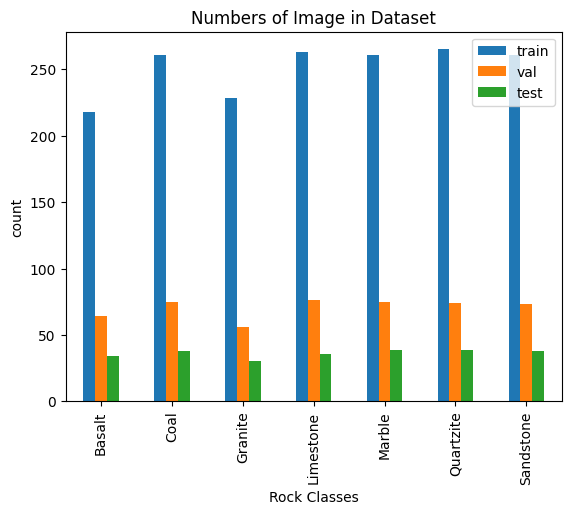

In [12]:
data = pd.DataFrame({
    "train": CountEachClass(train_dataset),
    "val": CountEachClass(val_dataset),
    "test": CountEachClass(test_dataset)
    },
    index = classes
)

data.plot(kind="bar")
plt.title("Numbers of Image in Dataset")
plt.xlabel("Rock Classes")
plt.ylabel("count")

Decode Indexed Class Label into Classname Label
************

In [13]:
def decode_target_index(index):
    
    label = classes
    return label[index]

Display Example of Training Data
************

Text(0.5, 0.98, 'Training Data')

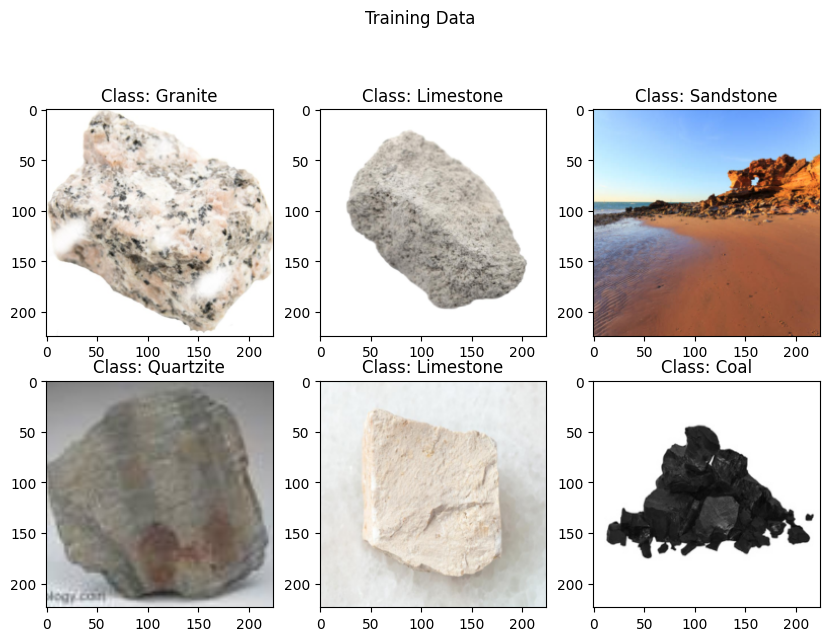

In [14]:
plt.figure(figsize=(10,10))

for i in range(6):
    rand_img = random.choice(list(train_dataset))
    
    img = rand_img["pixel_values"]
    rescale_img = (img/2+0.5)*255
    rescale_img = rescale_img.permute(1, 2, 0)
    rescale_img = rescale_img.detach().numpy()
    rescale_img = rescale_img.astype(np.uint8)
    plt.subplot(3,3,i+1)
    plt.imshow(rescale_img)
    plt.title("Class: "+decode_target_index(rand_img["label"]))

plt.suptitle("Training Data")

Define Model and Feature Extractor For Transfer Learning
********

In [15]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=7)

# Download feature extractor from hub
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Creat Compute Metric Function
********

In [16]:
# Compute metrics function for binary classification
acc_metric = evaluate.load("accuracy", module_type="metric")

def compute_metrics(eval_pred):
    predicted_probs, labels = eval_pred
    # Accuracy
    predicted_labels = np.argmax(predicted_probs, axis=1)
    acc = acc_metric.compute(predictions=predicted_labels, references=labels)
    return acc

Config Model id,label Transformation
*************

In [17]:
id2label = {key:train_dataset.features["label"].names[index] for index,key in enumerate(model.config.id2label.keys())}
label2id = {train_dataset.features["label"].names[index]:value for index,value in enumerate(model.config.label2id.values())}
model.config.id2label = id2label
model.config.label2id = label2id

Define Training Parameters
**********

In [18]:
# Total number of training epochs to perform
num_train_epochs = 15
# The batch size per GPU/TPU core/CPU for training
per_device_train_batch_size = 16
# The batch size per GPU/TPU core/CPU for evaluation
per_device_eval_batch_size = 16
# The initial learning rate for AdamW optimizer
learning_rate = 2e-5
# Number of steps used for a linear warmup from 0 to learning_rate
warmup_steps = 500
# The weight decay to apply to all layers except all bias and LayerNorm weights in AdamW optimizer
weight_decay = 0.01

main_metric_for_evaluation = "accuracy"

Define Training Arguments
*******

In [19]:
training_args = TrainingArguments(
    output_dir = model_dir,
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = per_device_eval_batch_size,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    logging_dir = f"{output_data_dir}/logs",
    learning_rate = float(learning_rate),
    load_best_model_at_end = True,
    metric_for_best_model = main_metric_for_evaluation,
)


Create Trainer instance
****

In [20]:
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = default_data_collator,
    tokenizer = feature_extractor
)

Finetuning Model
********

In [21]:
torch.cuda.empty_cache()
trainer.train() 

  7%|▋         | 110/1650 [02:09<27:06,  1.06s/it]

{'loss': 1.9251, 'grad_norm': 1.943577766418457, 'learning_rate': 4.4e-06, 'epoch': 1.0}


                                                  
  7%|▋         | 110/1650 [02:24<27:06,  1.06s/it]

{'eval_loss': 1.8999546766281128, 'eval_accuracy': 0.29411764705882354, 'eval_runtime': 14.9537, 'eval_samples_per_second': 32.968, 'eval_steps_per_second': 2.073, 'epoch': 1.0}


 13%|█▎        | 220/1650 [04:31<25:22,  1.06s/it]  

{'loss': 1.8097, 'grad_norm': 2.313769817352295, 'learning_rate': 8.8e-06, 'epoch': 2.0}


                                                  
 13%|█▎        | 220/1650 [04:46<25:22,  1.06s/it]

{'eval_loss': 1.7504550218582153, 'eval_accuracy': 0.5578093306288032, 'eval_runtime': 14.8231, 'eval_samples_per_second': 33.259, 'eval_steps_per_second': 2.091, 'epoch': 2.0}


 20%|██        | 330/1650 [06:51<24:50,  1.13s/it]  

{'loss': 1.5478, 'grad_norm': 2.135363817214966, 'learning_rate': 1.3200000000000002e-05, 'epoch': 3.0}


                                                  
 20%|██        | 330/1650 [07:06<24:50,  1.13s/it]

{'eval_loss': 1.4598217010498047, 'eval_accuracy': 0.6835699797160243, 'eval_runtime': 15.1945, 'eval_samples_per_second': 32.446, 'eval_steps_per_second': 2.04, 'epoch': 3.0}


 27%|██▋       | 440/1650 [09:09<21:13,  1.05s/it]  

{'loss': 1.1452, 'grad_norm': 2.0588650703430176, 'learning_rate': 1.76e-05, 'epoch': 4.0}


                                                  
 27%|██▋       | 440/1650 [09:24<21:13,  1.05s/it]

{'eval_loss': 1.088688611984253, 'eval_accuracy': 0.7383367139959433, 'eval_runtime': 15.1801, 'eval_samples_per_second': 32.477, 'eval_steps_per_second': 2.042, 'epoch': 4.0}


 33%|███▎      | 550/1650 [11:29<19:06,  1.04s/it]  

{'loss': 0.749, 'grad_norm': 2.5502004623413086, 'learning_rate': 1.9130434782608697e-05, 'epoch': 5.0}


                                                  
 33%|███▎      | 550/1650 [11:44<19:06,  1.04s/it]

{'eval_loss': 0.8022165894508362, 'eval_accuracy': 0.7789046653144016, 'eval_runtime': 14.746, 'eval_samples_per_second': 33.433, 'eval_steps_per_second': 2.102, 'epoch': 5.0}


 40%|████      | 660/1650 [13:48<17:16,  1.05s/it]  

{'loss': 0.4629, 'grad_norm': 3.2574965953826904, 'learning_rate': 1.721739130434783e-05, 'epoch': 6.0}


                                                  
 40%|████      | 660/1650 [14:03<17:16,  1.05s/it]

{'eval_loss': 0.6511808633804321, 'eval_accuracy': 0.8174442190669371, 'eval_runtime': 14.7282, 'eval_samples_per_second': 33.473, 'eval_steps_per_second': 2.105, 'epoch': 6.0}


 47%|████▋     | 770/1650 [16:07<15:40,  1.07s/it]  

{'loss': 0.2881, 'grad_norm': 1.588706612586975, 'learning_rate': 1.5304347826086958e-05, 'epoch': 7.0}


                                                  
 47%|████▋     | 770/1650 [16:21<15:40,  1.07s/it]

{'eval_loss': 0.5664154291152954, 'eval_accuracy': 0.8336713995943205, 'eval_runtime': 14.7667, 'eval_samples_per_second': 33.386, 'eval_steps_per_second': 2.099, 'epoch': 7.0}


 53%|█████▎    | 880/1650 [18:43<13:27,  1.05s/it]  

{'loss': 0.186, 'grad_norm': 3.708448886871338, 'learning_rate': 1.3391304347826088e-05, 'epoch': 8.0}


                                                  
 53%|█████▎    | 880/1650 [18:57<13:27,  1.05s/it]

{'eval_loss': 0.5780796408653259, 'eval_accuracy': 0.8316430020283976, 'eval_runtime': 14.7408, 'eval_samples_per_second': 33.445, 'eval_steps_per_second': 2.103, 'epoch': 8.0}


 60%|██████    | 990/1650 [21:00<11:29,  1.04s/it]  

{'loss': 0.1335, 'grad_norm': 0.30346232652664185, 'learning_rate': 1.1478260869565218e-05, 'epoch': 9.0}


                                                  
 60%|██████    | 990/1650 [21:15<11:29,  1.04s/it]

{'eval_loss': 0.5460819602012634, 'eval_accuracy': 0.8438133874239351, 'eval_runtime': 14.7931, 'eval_samples_per_second': 33.326, 'eval_steps_per_second': 2.096, 'epoch': 9.0}


 67%|██████▋   | 1100/1650 [23:18<09:35,  1.05s/it] 

{'loss': 0.107, 'grad_norm': 0.32537293434143066, 'learning_rate': 9.565217391304349e-06, 'epoch': 10.0}


                                                   
 67%|██████▋   | 1100/1650 [23:32<09:35,  1.05s/it]

{'eval_loss': 0.5572128891944885, 'eval_accuracy': 0.8417849898580122, 'eval_runtime': 14.7861, 'eval_samples_per_second': 33.342, 'eval_steps_per_second': 2.097, 'epoch': 10.0}


 73%|███████▎  | 1210/1650 [25:59<07:37,  1.04s/it]  

{'loss': 0.0911, 'grad_norm': 0.24697111546993256, 'learning_rate': 7.652173913043479e-06, 'epoch': 11.0}


                                                   
 73%|███████▎  | 1210/1650 [26:14<07:37,  1.04s/it]

{'eval_loss': 0.5606600046157837, 'eval_accuracy': 0.8377281947261663, 'eval_runtime': 14.7505, 'eval_samples_per_second': 33.423, 'eval_steps_per_second': 2.102, 'epoch': 11.0}


 80%|████████  | 1320/1650 [28:19<05:46,  1.05s/it]

{'loss': 0.0828, 'grad_norm': 0.24403730034828186, 'learning_rate': 5.739130434782609e-06, 'epoch': 12.0}


                                                   
 80%|████████  | 1320/1650 [28:34<05:46,  1.05s/it]

{'eval_loss': 0.5634639859199524, 'eval_accuracy': 0.8316430020283976, 'eval_runtime': 14.7012, 'eval_samples_per_second': 33.535, 'eval_steps_per_second': 2.109, 'epoch': 12.0}


 87%|████████▋ | 1430/1650 [30:37<04:06,  1.12s/it]

{'loss': 0.0766, 'grad_norm': 0.23545169830322266, 'learning_rate': 3.8260869565217395e-06, 'epoch': 13.0}


                                                   
 87%|████████▋ | 1430/1650 [30:52<04:06,  1.12s/it]

{'eval_loss': 0.5760470032691956, 'eval_accuracy': 0.821501014198783, 'eval_runtime': 15.0899, 'eval_samples_per_second': 32.671, 'eval_steps_per_second': 2.054, 'epoch': 13.0}


 93%|█████████▎| 1540/1650 [32:55<01:55,  1.05s/it]

{'loss': 0.0721, 'grad_norm': 0.20436854660511017, 'learning_rate': 1.9130434782608697e-06, 'epoch': 14.0}


                                                   
 93%|█████████▎| 1540/1650 [33:09<01:55,  1.05s/it]

{'eval_loss': 0.5793240666389465, 'eval_accuracy': 0.821501014198783, 'eval_runtime': 14.7346, 'eval_samples_per_second': 33.459, 'eval_steps_per_second': 2.104, 'epoch': 14.0}


100%|██████████| 1650/1650 [35:12<00:00,  1.11s/it]

{'loss': 0.0699, 'grad_norm': 0.20128989219665527, 'learning_rate': 0.0, 'epoch': 15.0}


                                                   
100%|██████████| 1650/1650 [35:28<00:00,  1.11s/it]

{'eval_loss': 0.5770719051361084, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 15.1407, 'eval_samples_per_second': 32.561, 'eval_steps_per_second': 2.047, 'epoch': 15.0}


100%|██████████| 1650/1650 [35:30<00:00,  1.29s/it]

{'train_runtime': 2130.3731, 'train_samples_per_second': 12.371, 'train_steps_per_second': 0.775, 'train_loss': 0.5831196221438322, 'epoch': 15.0}


TrainOutput(global_step=1650, training_loss=0.5831196221438322, metrics={'train_runtime': 2130.3731, 'train_samples_per_second': 12.371, 'train_steps_per_second': 0.775, 'train_loss': 0.5831196221438322, 'epoch': 15.0})

Show Training History
********

In [22]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history.fillna(0)
log_history = log_history.groupby(['epoch']).sum()
log_history

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1.0,1.9251,1.943578,0.000004,220,1.899955,0.294118,14.9537,32.968,2.073,0.0000,0.000,0.000,0.000000e+00,0.00000
2.0,1.8097,2.313770,0.000009,440,1.750455,0.557809,14.8231,33.259,2.091,0.0000,0.000,0.000,0.000000e+00,0.00000
3.0,1.5478,2.135364,0.000013,660,1.459822,0.683570,15.1945,32.446,2.040,0.0000,0.000,0.000,0.000000e+00,0.00000
4.0,1.1452,2.058865,0.000018,880,1.088689,0.738337,15.1801,32.477,2.042,0.0000,0.000,0.000,0.000000e+00,0.00000
5.0,0.7490,2.550200,0.000019,1100,0.802217,0.778905,14.7460,33.433,2.102,0.0000,0.000,0.000,0.000000e+00,0.00000
6.0,0.4629,3.257497,0.000017,1320,0.651181,0.817444,14.7282,33.473,2.105,0.0000,0.000,0.000,0.000000e+00,0.00000
7.0,0.2881,1.588707,0.000015,1540,0.566415,0.833671,14.7667,33.386,2.099,0.0000,0.000,0.000,0.000000e+00,0.00000
8.0,0.1860,3.708449,0.000013,1760,0.578080,0.831643,14.7408,33.445,2.103,0.0000,0.000,0.000,0.000000e+00,0.00000
9.0,0.1335,0.303462,0.000011,1980,0.546082,0.843813,14.7931,33.326,2.096,0.0000,0.000,0.000,0.000000e+00,0.00000


Display loss curve
********

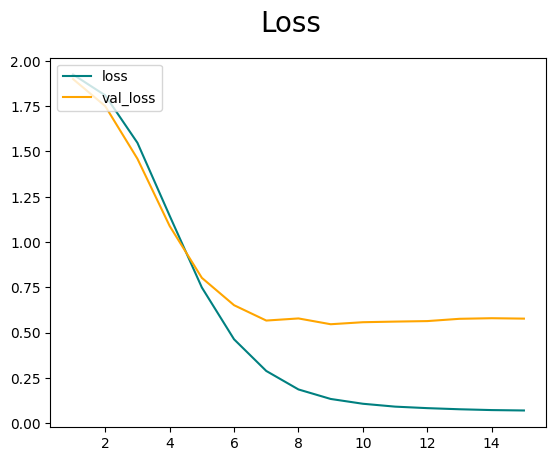

In [23]:
fig = plt.figure()
plt.plot(log_history['loss'], color='teal', label='loss')
plt.plot(log_history['eval_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Display Accuracy curve
********

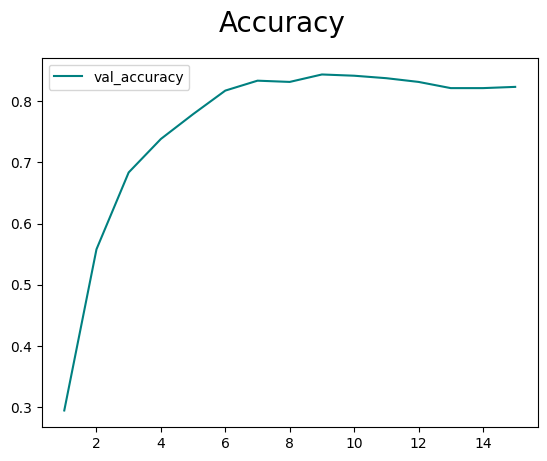

In [24]:
fig = plt.figure()
plt.plot(log_history['eval_accuracy'], color='teal', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Show Evaluation Result
********

In [25]:
metrics = trainer.evaluate(test_dataset)
trainer.log_metrics("test",metrics)
trainer.save_metrics("test",metrics)

100%|██████████| 16/16 [00:07<00:00,  2.02it/s]

***** test metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.8346
  eval_loss               =     0.5643
  eval_runtime            = 0:00:08.56
  eval_samples_per_second =     29.669
  eval_steps_per_second   =      1.869


Test Model
********

In [26]:
y_test = trainer.predict(test_dataset)
y_test_acual = y_test.label_ids
y_test_pred = np.argmax(y_test.predictions, axis=1)
Y_pred_Df = pd.DataFrame(y_test_pred)
Y_test_Df = pd.DataFrame(y_test_acual)

100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Display Confusion Metrix
********

Text(0.5, 1.0, 'Confusion Matrix')

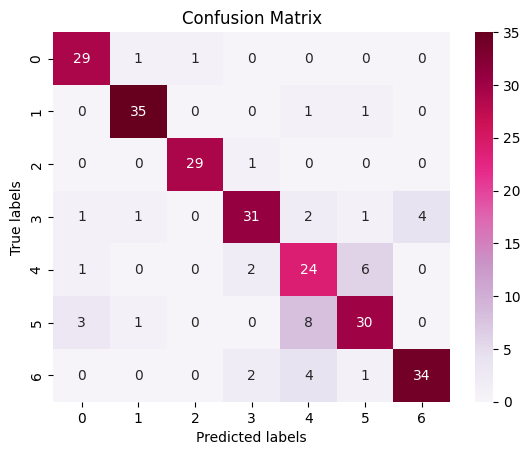

In [27]:
# Generate Confusion Metrix
cm = confusion_matrix(Y_pred_Df,Y_test_Df)
ax= plt.subplot()
sns.heatmap(cm, cmap='PuRd', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# Set label,title name
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Show Classification Report
********

In [28]:
print(classification_report(Y_test_Df,Y_pred_Df, target_names=(train_dataset.features["label"].names)))

              precision    recall  f1-score   support

      Basalt       0.94      0.85      0.89        34
        Coal       0.95      0.92      0.93        38
     Granite       0.97      0.97      0.97        30
   Limestone       0.78      0.86      0.82        36
      Marble       0.73      0.62      0.67        39
   Quartzite       0.71      0.77      0.74        39
   Sandstone       0.83      0.89      0.86        38

    accuracy                           0.83       254
   macro avg       0.84      0.84      0.84       254
weighted avg       0.84      0.83      0.83       254



Get All Wrong Prediction Image
********

In [29]:
wrong_predict={}
for i in range(0, Y_test_Df.shape[0]):
    V = list(Y_test_Df[0])
    K = list(Y_pred_Df[0])

    if (V[i] != K[i]):
        wrong_predict.update({i:(V[i],K[i])})

Display Example of Wrong Prediction Image
********

Text(0.5, 0.98, 'Wrong Prediction')

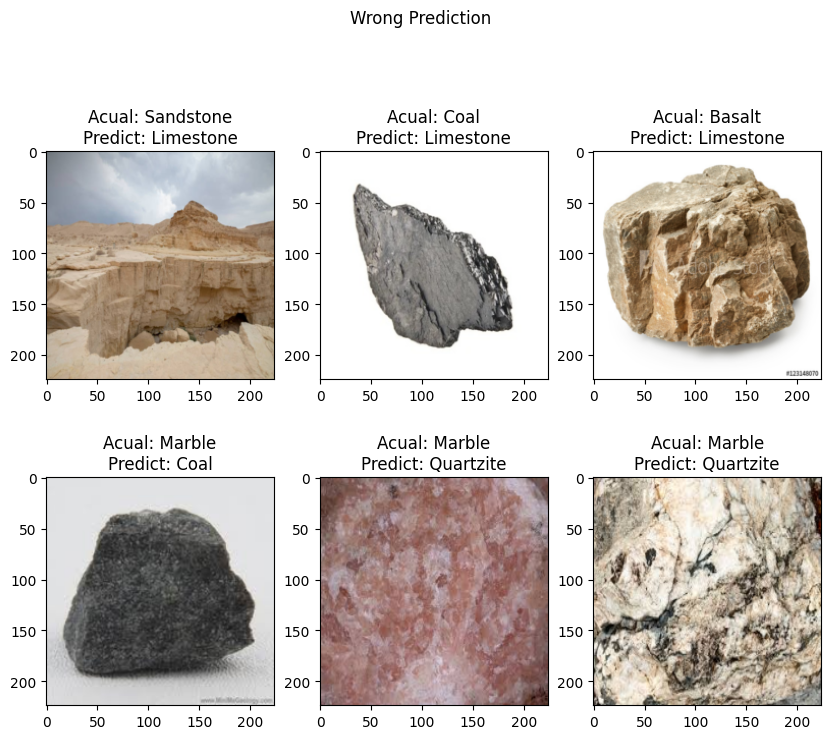

In [30]:
plt.figure(figsize=(10,12))

for i in range(6):
    img, result = random.choice(list(wrong_predict.items()))
    rescale_img = test_dataset[img]["pixel_values"]
    rescale_img = (rescale_img/2+0.5)*255
    rescale_img = rescale_img.permute(1, 2, 0)
    rescale_img = rescale_img.detach().numpy()
    rescale_img = rescale_img.astype(np.uint8)
    plt.subplot(3,3,i+1)
    plt.imshow(rescale_img)
    plt.title("Acual: "+decode_target_index(result[0])+"\nPredict: "+decode_target_index(result[1]))

plt.suptitle("Wrong Prediction")